In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from IPython.display import display
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [2]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(400)

In [3]:
path_to_positive_data = 'positive.csv' # путь к файлу, из которого берутся данные для обучения
path_to_negative_data = 'negative.csv'

path_to_processed_positive_data = "my_pos_text.csv"
path_to_processed_negative_data = "my_neg_text.csv"

target = 'text' # название взятой величины из файла

In [4]:
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 20 # кол-во эпох без улучшений
ES_min_delta = 0.001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'val_loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
RLPOP_factor = 0.1 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 15 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
maxWordsCount = 6000 #15000
max_text_len = 10
FIT_batch_size = 800 #1200 #1600 #1000 #250 #400 #500 #500 #10 #8 #15

In [5]:
# разделить данные на тренировочные и тестовые
def split(X,Y,factor):
    X_train=X[:factor]
    Y_train=Y[:factor]
    X_test=X[factor:]
    Y_test=Y[factor:]
    return X_train,Y_train,X_test,Y_test

In [6]:
# извлечь датасет из файла
def get_df(path, target_name = '2', serarator = ',', col_names = ['1','2']):
    
    file = pd.read_csv(path, sep = serarator, names = col_names)
    dframe = pd.DataFrame(file[target_name])
    return dframe

In [7]:
def remove_english(df):
    temp = list()
    for index, row in df.iterrows():
        temp.append("".join([w for w in row[target] if not re.match(r'[A-Z]+', w, re.I)]))
    return temp

In [8]:
# если оригинальный датасет не обрабатывался - обработать и создать новый
temp_names = ["id","name","text","her1","her2","her3",
                  "her4","her5","her6","her7","her8"] # названия колонок для ориг датасета 

if not os.path.exists(path_to_processed_positive_data):
    pos_df = get_df(path_to_positive_data, target, ";", temp_names)
    
    pos_text = remove_english(pos_df)
    pos_df = pd.DataFrame(pos_text)
    
    pos_df.to_csv(path_to_processed_positive_data, header = False)
else:
    pos_df = get_df(path_to_processed_positive_data)
    pos_text = pos_df['2'].values.tolist()
    
# если оригинальный датасет не обрабатывался - обработать и создать новый    
if not os.path.exists(path_to_processed_negative_data):
    neg_df = get_df(path_to_negative_data, target, ";", temp_names)
    
    neg_text = remove_english(neg_df)
    neg_df = pd.DataFrame(neg_text)
    
    neg_df.to_csv(path_to_processed_negative_data, header = False)
else:
    neg_df = get_df(path_to_processed_negative_data)
    neg_text = neg_df['2'].values.tolist()

print("pos_text: ", np.array(pos_text[:10]))
print("neg_text: ", np.array(neg_text[:10]))

pos_text:  ['@_ хоть я и школота, но поверь, у нас то же самое : общество профилирующий предмет типа)'
 'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:'
 ' @: Ну ты идиотка) я испугалась за тебя!!!'
 ' @2912: "Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим" : ://./62…'
 '@_ Вот что значит страшилка :\r\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :'
 'ну любишь или нет? — Я не знаю кто ты бля: ://./916'
 ' @: Ох,900 : ну это конечно же @ . Чтобы у нее было много друзей, ведь она такая мимими &;3'
 ' @: У тебя есть ухажёр? Нет - мои уши не кто не жрёт :'
 'Поприветствуем моего нового читателя @1789 ;)'
 'Теперь у меня есть частичка Сиднея :) # # ://./3']
neg_text:  ['на работе был полный пиддес :| и так каждое закрытие месяца, я же свихнусь так :'
 'Коллеги сидят рубятся в  , а я из-за долбанной винды не могу :('
 '@_4 как говорят обещаного три года ждут...(('
 'Желаю хорошего по

In [9]:
texts = pos_text + neg_text
count_true = len(pos_text)
count_false = len(neg_text)
total_lines = count_true + count_false
print(
    "pos_text_num: ", count_true, 
    "\nneg_text_num: ", count_false,
    "\nall_text_num: ", total_lines)

pos_text_num:  114911 
neg_text_num:  111923 
all_text_num:  226834


In [10]:
X_data = np.array(texts)

Y_data = np.array([1]*count_true + [0]*count_false)
print(X_data.shape, Y_data.shape)

indeces = np.random.choice(X_data.shape[0], size = X_data.shape[0], replace=False)

print("indeces: ", indeces)

X_data = X_data[indeces]
Y_data = Y_data[indeces]

factor = int(.80 * X_data.shape[0])

X_train,Y_train,X_test,Y_test = split(X_data,Y_data,factor)

print("train: ", X_train.shape, Y_train.shape, type(X_train), type(Y_train))
print("test: ", X_test.shape, Y_test.shape, type(X_test), type(Y_test))

for x in range(5):
    print(X_train[x], Y_train[x])

(226834,) (226834,)
indeces:  [ 48642 208321  32328 ... 198974  69071 119132]
train:  (181467,) (181467,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
test:  (45367,) (45367,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Планшет шалит. Перемещает картинки из одной папки в другую. У меня фото Уэя в фартучке в папке с котятами. Хотя стойте, все правильно: 1
мои съёмки постоянно куда то переносятся.
я когда нибудь отщелкаю пленку? Мю:( 0
 @_: Ну поймёт только лучшая подруга :) 1
@ @ бизнес с друзьями заводить нельзя :( 0
 @_: Настя подари мне щастья подари мне радость подари любовь :
Азазаза 1


In [11]:
#print(X.shape)
#LSTM?
#Sequential.compile?
#equential.fit?

In [12]:
#Sequential model с преобработкой
vectproc = tf.keras.layers.experimental.preprocessing.TextVectorization( #tf.keras.layers.TextVectorization(
    max_tokens = maxWordsCount, 
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = max_text_len,
    )

text_dataset = tf.data.Dataset.from_tensor_slices(texts)

vectproc.adapt(text_dataset.batch(64))

model = tf.keras.models.Sequential()

model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectproc)
model.add(Embedding(maxWordsCount, output_dim = 64, input_length = max_text_len)) #128
#model.add(LSTM(units = 128, return_sequences = True, dropout = 0.3))
model.add(LSTM(units = 64, return_sequences = True, dropout = 0.4))
model.add(LSTM(units = 16, dropout = 0.4))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 10)                0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 64)            384000    
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 422,225
Trainable params: 422,225
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [14]:
model.compile(loss = 'binary_crossentropy',#'mean_squared_error', 
              metrics=['accuracy'], 
              # learning_rate = 0.1
              optimizer = tf.keras.optimizers.SGD(learning_rate = 0.2, momentum = 0.8, nesterov = True)) #0.1))#0.08))
#tf.keras.optimizers.SGD(learning_rate = 0.01)) #0.01
# tf.keras.optimizers.SGD(learning_rate = 0.0001)) #0.05)) #Adam(0.0003)) #'categorical_crossentropy'

In [15]:
#tf.keras.models.Sequential.fit?

In [16]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size = FIT_batch_size, 
                    shuffle = True, 
                    verbose = 1, 
                    epochs = 100, #100, #30, 
                    validation_split = 0.15,
                    #steps_per_epoch = 3000,
                    callbacks = FIT_callback_list)

193/193 [==============================] - 14s 71ms/step - loss: 0.5203 - accuracy: 0.7322 - val_loss: 0.5840 - val_accuracy: 0.6928


In [17]:
#Sequential.fit?

In [18]:
#reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [25]:
for x in range(40): 
    
    a = np.array([X_test[x]])
    
    #print(a)
    
    res = model.predict(a)  
    
    #print(res) 
    
    mark = "Положительно" if np.mean(res) > 0.5 else "Отрицательно"
    mark2 = "Положительно" if Y_test[x] == 1 else "Отрицательно"
    equal = "==" if mark == mark2 else "  "
    
    print((f"Maybe[{mark}] [%.4f] " % np.mean(res)) , equal , f" Right[{mark2}]\t" , X_test[x])


Maybe[Положительно] [0.6205]  ==  Right[Положительно]	 Я ТЕБЯ БУМ БУМ БУМ : — ТЫ МЕНЯ БУМ БУМ БУМ : ://./21
Maybe[Положительно] [0.5380]      Right[Отрицательно]	 Будь я мужчиной геем и причем русским,я бы не осмелилась пожениться с мужчиной,потому что Россия страна гомофобов((( ://./76
Maybe[Положительно] [0.7992]  ==  Right[Положительно]	 Россол   с утра отличная вещь после бурного вечера)
Maybe[Положительно] [0.7017]  ==  Right[Положительно]	 @_ Ну я прям и не знаю кому из вас верить ;) ://./
Maybe[Положительно] [0.5619]  ==  Right[Положительно]	 бумажный скотч спасет мир!мне не чем было зафиксировать бинт вокруг пальца и тут пришел ОН - бумажный скотч!))
Maybe[Отрицательно] [0.3432]  ==  Right[Отрицательно]	 Хух,так переживаю!!!Наче  Шепард від мене йде, а не від Грей(((((ппц((
Maybe[Отрицательно] [0.2889]  ==  Right[Отрицательно]	  @: Пополнили коллекцию кошек. Теперь приходится слушать мявканье целый день и ночь:(
Maybe[Отрицательно] [0.1055]  ==  Right[Отрицательно]	 Очень обидн

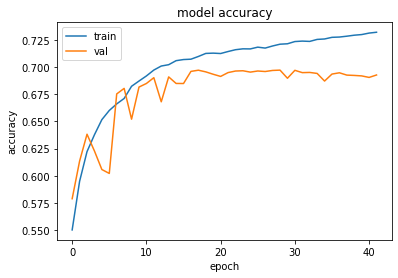

In [20]:
# Вывод графика изменения ошибки
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [21]:
# тест модели
model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)

57/57 [==============================] - 2s 27ms/step - loss: 0.5690 - accuracy: 0.6979


[0.5689572095870972, 0.6978641152381897]

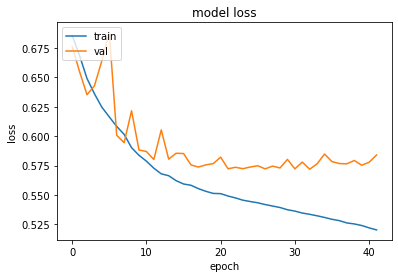

In [22]:
# Вывод графика изменения ошибки
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [23]:
t = "если вы просто посмотрите на жизнь позитивно произойдут позитивные вещи"

a = list()
a.append(t)
a = np.array(a)

#res = model.predict(data_pad)
res = model.predict(a)

mark = "Положительно" if np.mean(res) > 0.5 else "отрицательно"

print(f"mark [{mark}]")
print("res: ", res)
print("res[0,0]: ", res[0,0])

mark [Положительно]
res:  [[0.8706106]]
res[0,0]:  0.8706106


In [24]:
t = "это просто ужасно плохо противно не хорошо"

a = list()
a.append(t)
a = np.array(a)

#res = model.predict(data_pad)
res = model.predict(a)

mark = "Положительно" if np.mean(res) > 0.5 else "отрицательно"

print(f"mark [{mark}]")
print("res: ", res)
print("res[0,0]: ", res[0,0])

mark [отрицательно]
res:  [[0.03905198]]
res[0,0]:  0.03905198
